![](https://img.shields.io/badge/Community-Contribution-%20?color=grey&labelColor=yellow)

> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/datasets/SWOT_PIXC_Area_localmachine.ipynb). 

# SWOT PIXC Dataset Area Aggregation on a local machine

## How to aggregate PIXC data to estimate water body areas

### Requirement:
Local compute environment e.g. laptop, server: this tutorial can be run on your local machine.

### Learning Objectives:
- Learn how to aggregate water area over water features, scaling by the water fraction on land/water edges
- Access SWOT PIXC data products (archived in NASA Earthdata Cloud) by downloading to local machine
- Visualize accessed data, isolate a single water feature (e.g., a lake) and call RiverObs tools aggerate water area

#### SWOT Level 2 KaRIn High Rate Version C (aka 2.0) Datasets:

1. **Water Mask Pixel Cloud Vector Attribute NetCDF** - SWOT_L2_HR_PIXCVec_2.0


_Notebook Author: Brent Williams (NASA JPL, July 2024)_

_Last updated: 7 July 2024_
  

### Libraries Needed

Note: To import SWOTWater, use the following pip install for the RiverObs GitHub repository:

> pip install git+https://github.com/SWOTAlgorithms/RiverObs.git --no-cache-dir

In [14]:
import os
# import sys

import glob
import h5netcdf
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import earthaccess
import SWOTWater.aggregate # In the SWOTAlgorithms/RiverObs Repository
import scipy.ndimage

from utils import *

### Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. If you don't already have one, please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up. We use `earthaccess` to authenticate your login credentials below.

In [3]:
auth = earthaccess.login()

#### **1. Water Mask Pixel Cloud NetCDF**

#### Search for data collection for specific tile

If you do not know the cycle, pass and tile number for your region of interest, see [this section in the PO.DAAC Cookbook](https://podaac.github.io/tutorials/quarto_text/SWOT.html#swot-spatial-coverage).

In [3]:
# pixc_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0', 
                                        granule_name = '*530_013_233L_*') # Willamette 

Granules found: 1


Let's download one data file! earthaccess.download has a list as the input format, so we need to put brackets around the single file we pass.

In [6]:
# earthaccess.download([pixc_results[0]], "./data_downloads")

### Pixel Cloud

In [16]:
huc2 = '01' ### SET THIS
data_path = '/nas/cee-water/cjgleason/fiona/data/PIXC_v2_0_HUC2_' + huc2

In [4]:
# Get job index
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
index = 106

In [10]:
huc2 = '01'
file_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/PIXC_v2_0_HUC2_' + huc2 + '_filtered.json'
data = open_json(file_path)

In [11]:
file_name = data[index]

In [12]:
# Get data for this tile
granule_name = file_name[:-3]
tile_name = file_name[20:28]
pass_num = int(file_name[20:23])

print(granule_name)

SWOT_L2_HR_PIXC_002_007_235R_20230811T080638_20230811T080649_PGC0_01


#### Read in PIXC

In [17]:
# Set PIXC filepath
pixc_path = os.path.join(data_path, file_name)

In [18]:
# Read in pixel group
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group = 'pixel_cloud', engine='h5netcdf')

In [13]:
# ds_PIXC.load_tide_fes

In [19]:
# # Make mask
# mask = bitwiseMask(ds_PIXC)

# if mask.shape[0] == 0:
#     print('This granule has no pixels after masking, exiting.')
#     # sys.exit(1)    

In [20]:
# # Set desired data vars
# variables = ['azimuth_index', 'range_index', 'cross_track',
#              'pixel_area', 'height', 'geoid', 'solid_earth_tide', ## HERE
#              'load_tide_fes', 'pole_tide', 'prior_water_prob', ## HERE
#              'classification']

In [16]:
# # Convert PIXC to GeoDataFrame
# gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)

#### Open data using xarray

The pixel cloud netCDF files are formatted with three groups titled, "pixel cloud", "tvp", or "noise" (more detail [here](https://podaac-tools.jpl.nasa.gov/drive/files/misc/web/misc/swot_mission_docs/pdd/D-56411_SWOT_Product_Description_L2_HR_PIXC_20200810.pdf)). In order to access the coordinates and variables within the file, a group must be specified when calling xarray open_dataset.

In [21]:
# ds_PIXC = xr.open_mfdataset("data_downloads/SWOT_L2_HR_PIXC_*530_013_233L*.nc", group = 'pixel_cloud', engine='h5netcdf')
# ds_PIXC

#### Plot the PIXC data only for good/detected water
This plot is still hard to see, so we will crop around a paticular water-body of interest below

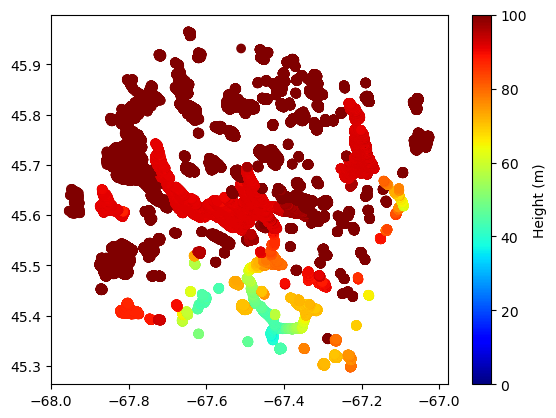

In [22]:
# mask to get good water pixels
mask = np.where(np.logical_and(ds_PIXC.classification > 2, ds_PIXC.geolocation_qual <4))
plt.scatter(x=ds_PIXC.longitude[mask], y=ds_PIXC.latitude[mask], c=ds_PIXC.height[mask], cmap='jet')
plt.clim((0,100))
plt.colorbar().set_label('Height (m)')
# alternatively wrap the height colorbar at 10m...sometimes this is usefull
# (e.g., we want to see fine height structure, but the range of heights is large)
#plt.scatter(x=ds_PIXC.longitude[mask], y=ds_PIXC.latitude[mask], c=np.mod(ds_PIXC.height[mask], 10), cmap='hsv')
#plt.colorbar().set_label('Height (m), 10 m wrap')


#### Make function to map a PIXC variable to slant-plane/radar coordiantes

In [23]:
def toslant(pixc, key='height'):
    az = pixc.azimuth_index.astype(int)
    rng = pixc.range_index.astype(int)
    out = np.zeros((pixc.interferogram_size_azimuth + 1, pixc.interferogram_size_range + 1)) + np.nan
    var = pixc[key]
    out[az, rng] = var
    return out

#### Get the desired data variables in slant plane

In [27]:
height = toslant(ds_PIXC, key='height')
klass = toslant(ds_PIXC, key='classification')
pixel_area = toslant(ds_PIXC, key='pixel_area')
water_frac = toslant(ds_PIXC, key='water_frac')
water_frac_uncert = toslant(ds_PIXC, key='water_frac_uncert')
darea_dheight = toslant(ds_PIXC, key='darea_dheight')
Pfd = toslant(ds_PIXC, key='false_detection_rate')
Pmd = toslant(ds_PIXC, key='missed_detection_rate')
geoloc_qual = toslant(ds_PIXC, key='geolocation_qual')
lat = toslant(ds_PIXC, key='latitude')
lon = toslant(ds_PIXC, key='longitude')

#### Crop slant-plane images to be easier to work with and visualize

In [30]:
az0 = 2000
az1 = 2500
rng0 = 3000
rng1 = 4500

height = height[az0:az1, rng0:rng1]
klass = klass[az0:az1, rng0:rng1]
pixel_area = pixel_area[az0:az1, rng0:rng1]
water_frac = water_frac[az0:az1, rng0:rng1]
water_frac_uncert = water_frac_uncert[az0:az1, rng0:rng1]
darea_dheight = darea_dheight[az0:az1, rng0:rng1]
Pfd = Pfd[az0:az1, rng0:rng1]
Pmd = Pmd[az0:az1, rng0:rng1]
geoloc_qual = geoloc_qual[az0:az1, rng0:rng1]
lat = lat[az0:az1, rng0:rng1]
lon = lon[az0:az1, rng0:rng1]

#### Plot slant-plane height image with  10m wrap

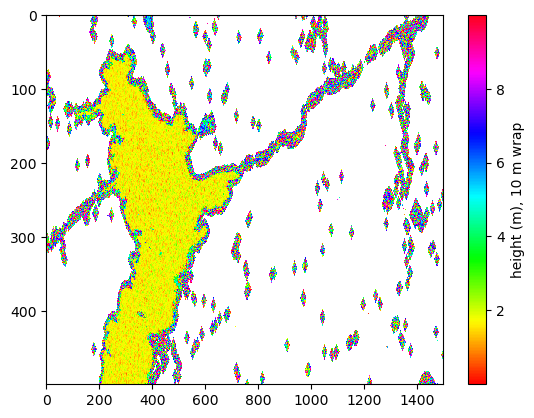

In [31]:
plt.imshow(np.mod(height, 10), interpolation='none', cmap='hsv', aspect='auto')
plt.colorbar().set_label('height (m), 10 m wrap')

#### Plot slant-plane classification image

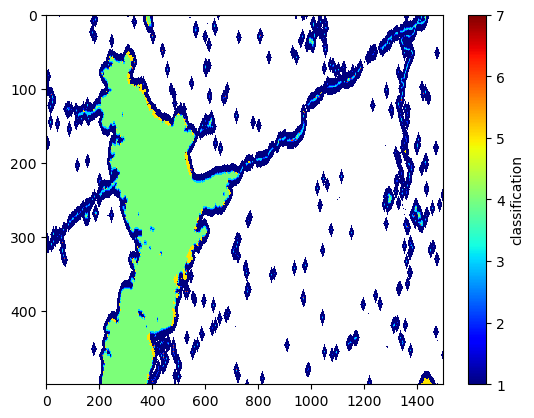

In [32]:
plt.imshow(klass, interpolation='none', cmap='jet', aspect='auto')
plt.colorbar().set_label('classification')

#### Plot ground plane height image of only good qual water pixels

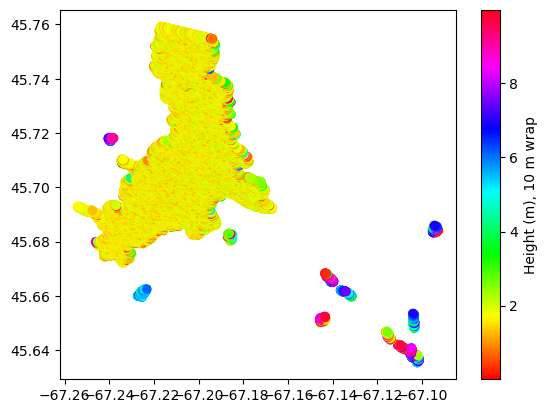

In [33]:
mask = np.where(np.logical_and(klass > 2, geoloc_qual <4))
plt.scatter(x=lon[mask], y=lat[mask], c=np.mod(height[mask], 10), cmap='hsv')
plt.colorbar().set_label('Height (m), 10 m wrap')

#### Get the detected water mask from the multi-value class-map and plot it

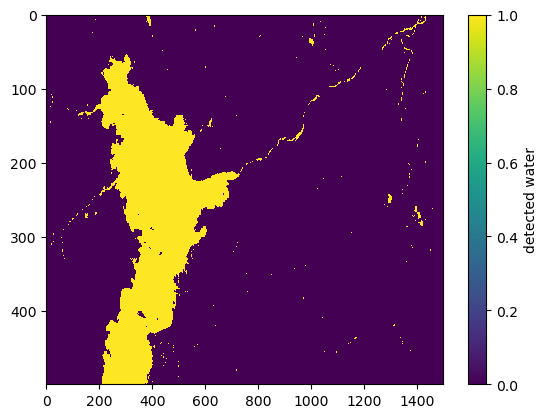

In [34]:
detected_water = np.zeros(np.shape(klass))
detected_water[klass>2] = 1
detected_water[klass==5] = 0 # set dark water as not detected

plt.imshow(detected_water, interpolation='none', aspect='auto')
plt.colorbar().set_label('detected water')

#### Segment the detected water image to separate out the different water features and focus on just the 1 lake and plot the label image

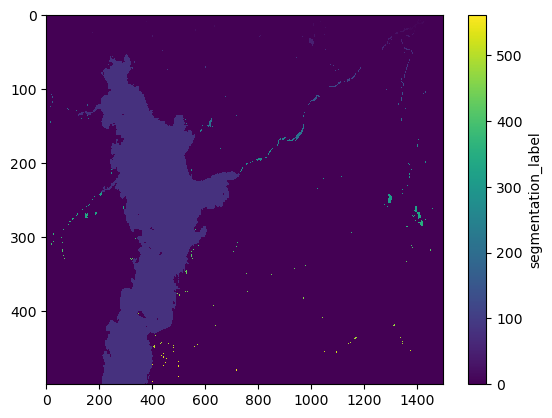

In [51]:
lab, nlabs = scipy.ndimage.label(detected_water)
plt.imshow(lab, interpolation='none', aspect='auto')
plt.colorbar().set_label('segmentation_label')

In [57]:
lab[0:100, 250:350]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [80, 80, 80, ..., 80, 80, 80],
       [80, 80, 80, ..., 80, 80, 80],
       [80, 80, 80, ..., 80, 80, 80]], dtype=int32)

#### Isolate out the one lake we want to assess

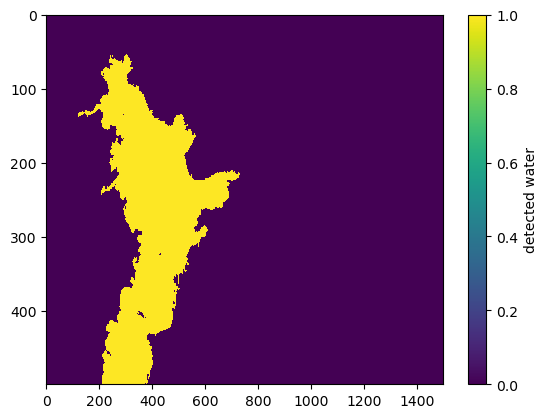

In [58]:
lake = np.zeros_like(detected_water)
lake[lab==80] = 1
# get the land-near-water pixels too
mask = np.zeros_like(detected_water)
mask[detected_water==1] = 1
mask[klass==2] = 1
iters = range(5)
for iter in iters:
    lake = scipy.ndimage.binary_dilation(lake)
    lake = lake * mask
lake[klass<=0] = 0
plt.imshow(lake, interpolation='none', aspect='auto')
plt.colorbar().set_label('detected water')

#### Mask out relvant variables to get ony lake pixels, where we also have valid SWOT data (in prep to call the RiverObs aggregation functions)

In [59]:
mask = np.logical_and(lake==1, pixel_area > 0)
klass_1d = klass[mask]
detected_water_1d = detected_water[mask]
pixel_area_1d = pixel_area[mask]
water_frac_1d = water_frac[mask]
water_frac_uncert_1d = water_frac_uncert[mask]
darea_dheight_1d = darea_dheight[mask]
Pfd_1d = Pfd[mask]
Pmd_1d = Pmd[mask]
good = np.where(np.ones_like(klass_1d)==1)

## Call the RiverObs area aggregation function(s)
 Now we are ready to call the area aggregation function in the RiverObs repo. Note that there is a function that aggregates area-only (SWOTWater.aggregate.area_only()), as well as one that estimates the area uncertainty at the same time (SWOTWater.aggregate.area_with_uncert).  Each of them have a 'method' parameter that can be set to 'composite', 'water_fraction', or 'simple'.  For most cases users should apply the 'composite' method, which will result in the least bias, while also minimizing the uncertainty.

 - The 'composite' method is what is used in river and lake processors. It directly aggregates the pixel area for interior water (and dark water) pixels, but scales pixel area by the water fraction on the edge pixels (both land near water and water near land).

 - The 'water_fraction' method scales by the water fraction estimate for all pixels

 - The 'simple method' just aggregates the pixel area directly for all detected water pixels

In [60]:
# call the area-only aggregator
area_comp, num_pixels_comp = SWOTWater.aggregate.area_only(
        pixel_area_1d, water_frac_1d, klass_1d, good,
        method='composite')

# call the full aggregation method that also computes the area uncertainty
area_agg, area_unc, area_pcnt_uncert = SWOTWater.aggregate.area_with_uncert(
        pixel_area_1d, water_frac_1d, water_frac_uncert_1d, darea_dheight_1d,
        klass_1d, Pfd_1d, Pmd_1d, good, method='composite')


In [61]:
# these other methods are alternatives that have different bias and error characteristics
# Users should almost always use the 'composite' method

# 'simple' method is just sum of pixel area over the detected water
# e.g., detected_area = np.sum(pixel_area_1d[good] * detected_water_1d[good])
area_simple, num_pixels_simple = SWOTWater.aggregate.area_only(
        pixel_area_1d, water_frac_1d, klass_1d, good,
        method='simple')
# 'water_fraction' method is just always scaling by water fraction for detected water and land near water
area_wf, num_pixels_wf = SWOTWater.aggregate.area_only(
        pixel_area_1d, water_frac_1d, klass_1d, good,
        method='water_fraction')

#### Compare the results from the different methods

In [62]:
# manually do a simple sum of pixel area for comparison
detected_area = np.sum(pixel_area_1d[good] * detected_water_1d[good])
# compute area percent diffferentce relative to the 'detected_area'
area_perc_diff_comp = (area_comp - detected_area)/np.sqrt(area_comp * detected_area)*100
area_perc_diff_simple = (area_simple - detected_area)/np.sqrt(area_simple * detected_area)*100
area_perc_diff_wf = (area_wf - detected_area)/np.sqrt(area_wf * detected_area)*100
# print out a table
print("Area estimates:")
print("method: \t composite, \t water_fraction, \t simple")
print("area:   \t {:10.1f}, \t {:10.1f}, \t{:10.1f}".format(area_comp, area_wf, area_simple))
print("area_diff:\t {:10.1f}, \t {:10.1f}, \t{:10.1f}".format(area_perc_diff_comp, area_perc_diff_wf, area_perc_diff_simple))


Area estimates:
method: 	 composite, 	 water_fraction, 	 simple
area:   	 22823721.7, 	 22441074.8, 	23205524.0
area_diff:	       -1.7, 	       -3.3, 	       0.0
